# Loading and Mounting



In [ ]:
!nvidia-smi

Tue May  4 07:14:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import torch
import torch.nn as nn 
import torch.optim as opt
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Data

In [ ]:
# Active State dictionary
# Feature: [start, end]
split = {
            'Andhra_Pradesh':[0,13],
            'Arunachal_Pradesh':[13,38],
            'Assam':[38,71],
            'Bihar':[71,109],
            'Chattisgarh':[109,137],
            'Goa':[137,139],
            'Gujarat':[139,172],
            'Haryana':[172,194],
            'Himanchal_Pradesh':[194,206],
            'Jharkhand':[206,230],
            'Karnataka':[230,260],
            'Kerala':[260,274],
            'Madhya_Pradesh':[274,329],
            'Maharashtra':[329,365],
            'Manipur':[365,381],
            'Meghalaya':[381,392],
            'Mizoram':[392,400],
            'Nagaland':[400,412],
            'Odisha':[412,442],
            'Punjab':[442,464],
            'Rajasthan':[464,497],
            'Sikkim':[497,501],
            'Tamil_Nadu':[501,539],
            'Telangana':[539,572],
            'Tripura':[572,580],
            'Uttar_Pradesh':[580,655],
            'Uttarakhand':[655,668],
            'West_Bengal':[668,691],
            'Andaman':[691,694],
            'Chandigarh':[694,695],
            'Daman':[695,698],
            'Jammu':[698,718],
            'Ladakh':[718,720],
            'Lakshadweep':[720,721],
            'Delhi':[721,732],
            'Puducherry':[732,736]
          }
death_margin = 736
recover_margin = 1472

In [ ]:
data = np.load('/gdrive/MyDrive/Trip-AID/3000varDataset.npy')

In [ ]:
data = np.transpose(data,(1,0))

(357, 2944)

In [ ]:
def Dataset(series,window=7,future=7):
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + window
    future_end = past_end + future
    if future_end > len(series):
      break
    _past, _future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(_past)
    y.append(_future)
  return np.array(X), np.array(y)

<function matplotlib.pyplot.show>

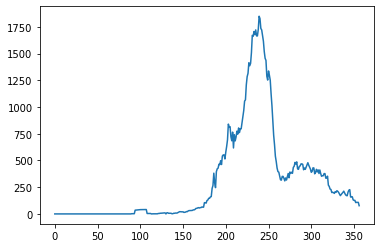

In [ ]:
data.shape
plt.plot(data[:,444],label = 'Actual')
plt.show

In [ ]:
data = data[75:]

In [ ]:
ds = data[:,split['Maharashtra'][0]:split['Maharashtra'][1]]

In [ ]:
ds.shape

(282, 36)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}

for i in range(ds.shape[1]):
  scale = MinMaxScaler(feature_range=(0,1))
  s = scale.fit_transform(ds[:,i].reshape(-1,1))
  ds[:,i] = s.reshape(len(ds))
  scalers['scaler_'+ str(i)] = scale
len(scalers)

36

In [ ]:
window = 14
future = 7
num_features = ds.shape[1]

X_ds, y_ds = Dataset(ds,window,future)
print(X_ds.shape,",",y_ds.shape)

(262, 14, 36) , (262, 7, 36)


In [ ]:
def seqSplit(data, label, split):
  '''
  Windowed data of shape: (Num_Samples, Window, Features)
  '''
  X_train = []
  X_test = []
  y_train = []
  y_test = []
  for i in range(data.shape[0]):
    _data = data[i,:,:]
    _label = label[i,:,:]
    if i % split == 0:
      X_test.append(_data)
      y_test.append(_label)
    else:
      X_train.append(_data)
      y_train.append(_label)
  return np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)

X_train, X_test, y_train, y_test = seqSplit(X_ds, y_ds, 4)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(196, 14, 36) (196, 7, 36)
(66, 14, 36) (66, 7, 36)


In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size=0.2, random_state=125678)

# print(X_train.shape,",",y_train.shape)
# print(X_test.shape,",",y_test.shape)

In [ ]:
# ctg = int(data.shape[1]/4) 

# split_time = 200
# train, test = data[:split_time,:13], data[split_time:,:13]
# print(train.shape)
# print(test.shape)

# from sklearn.preprocessing import MinMaxScaler

# scalers = {}
# for i in range(train.shape[1]):
#   scale = MinMaxScaler(feature_range=(0,1))
#   s = scale.fit_transform(train[:,i].reshape(-1,1))
#   train[:,i] = s.reshape(len(train))
#   scalers['scaler_'+ str(i)] = scale
  
# for i in range(train.shape[1]):
#   scale = scalers['scaler_'+ str(i)]
#   s = scale.transform(test[:,i].reshape(-1,1))
#   test[:,i] = s.reshape(len(test))

# window = 14
# future = 7
# num_features = data.shape[1]

# X_train, y_train = Dataset(train,window,future)
# X_test, y_test = Dataset(test,window,future)

# print(X_train.shape,y_train.shape)
# print(X_test.shape,y_test.shape)

In [ ]:
X_train = torch.from_numpy(X_train.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.astype('float32'))
y_test = torch.from_numpy(y_test.astype('float32'))

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
X_train = X_train.to(DEVICE)
X_test = X_test.to(DEVICE)
y_train = y_train.to(DEVICE)
y_test = y_test.to(DEVICE)

In [ ]:
torch.autograd.set_detect_anomaly(True) 

# Simple RHN Model

## Model Code

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
import torch
import torch.nn as nn
import torch.jit as jit
from typing import List
from torch import Tensor


class RHNCell(nn.Module):
    __constants__ = ['nb_rhn_layers', 'drop_prob', 'hidden_dim']

    def __init__(self, input_dim, hidden_dim, nb_rhn_layers, drop_prob):
        super(RHNCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nb_rhn_layers = nb_rhn_layers
        self.drop_prob = drop_prob

        self.drop_layer = nn.Dropout(drop_prob)
        self.input_fc = nn.Linear(input_dim, 2 * hidden_dim)
        self.first_fc_layer = nn.Linear(hidden_dim, 2 * hidden_dim)
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_dim, 2 * hidden_dim) for _ in range(nb_rhn_layers-1)])


    def highwayGate(self, hidden_states, s_t_l_minus_1):
        h, t = torch.split(hidden_states, self.hidden_dim, 1)
        h, t = torch.tanh(h), torch.sigmoid(t)
        c = 1 - t
        t = self.drop_layer(t)
        s_t = h * t + s_t_l_minus_1 * c
        return s_t


    def forward(self, x_t, s_t_l_0):

        hidden_states = self.input_fc(x_t) + self.first_fc_layer(s_t_l_0)
        s_t_l = self.highwayGate(hidden_states, s_t_l_0)

        s_t_l_minus_1 = s_t_l
        for fc_layer in self.fc_layers:
            hidden_states = fc_layer(s_t_l_minus_1)
            s_t_l = self.highwayGate(hidden_states, s_t_l_minus_1)
            s_t_l_minus_1 = s_t_l

        return s_t_l


class RHN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, nb_rhn_layers, drop_prob):
        super(RHN, self).__init__()

        self.rhncell = RHNCell(input_dim, hidden_dim, nb_rhn_layers, drop_prob)
        self.output_fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, input, s_t_0_l_0):

        inputs = input.unbind(1)
        s_t_minus_1_L = s_t_0_l_0
        outputs = torch.jit.annotate(List[Tensor], [])
        for t in range(len(inputs)):
            s_t_L = self.rhncell(inputs[t], s_t_minus_1_L)
            s_t_minus_1_L = s_t_L
            outputs += [s_t_L]

        x = torch.stack(outputs).transpose(0, 1)
        x = self.output_fc(x)
        return x

In [ ]:
input_dim = ds.shape[1]
output_dim = ds.shape[1]
hidden_dim = 120
nb_rhn_layers = 4

model = RHN(input_dim, hidden_dim, output_dim, nb_rhn_layers, drop_prob=0.3).to(DEVICE)
model

RHN(
  (rhncell): RHNCell(
    (drop_layer): Dropout(p=0.3, inplace=False)
    (input_fc): Linear(in_features=36, out_features=240, bias=True)
    (first_fc_layer): Linear(in_features=120, out_features=240, bias=True)
    (fc_layers): ModuleList(
      (0): Linear(in_features=120, out_features=240, bias=True)
      (1): Linear(in_features=120, out_features=240, bias=True)
      (2): Linear(in_features=120, out_features=240, bias=True)
    )
  )
  (output_fc): Linear(in_features=120, out_features=36, bias=True)
)

In [ ]:
loss_function = nn.SmoothL1Loss()
optimizer = opt.Adam(model.parameters(),lr=1e-3)
scheduler = None #opt.lr_scheduler.StepLR(optimizer,300,0.5)

## Training

In [ ]:
future = y_ds.shape[1]
model.train()
EPOCH = 2500
lossx = [i for i in range(EPOCH)]
testx= [i for i in range(EPOCH)]
lossy,testy= [],[]
for epoch in range(EPOCH):
    cumloss=0
    testloss=0

    model.zero_grad()
    optimizer.zero_grad()
    s_0 = torch.zeros(X_train.shape[0],hidden_dim).to(DEVICE)
    out = model(X_train, s_0)
    
    loss=loss_function(out[:,:future,:], y_train)
    loss.backward()
    mape_train = mean_absolute_percentage_error(out[:,:future,:].to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

    nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    
    cumloss += float(loss.data)
    lossy.append(cumloss)
    model.eval()
    with torch.no_grad():
        s_0 = torch.zeros(X_test.shape[0],hidden_dim).to(DEVICE)
        out_test = model(X_test,s_0)
        loss_test = loss_function(out_test[:,:future,:], y_test)
        testloss += float(loss_test.data)
        mape_test = mean_absolute_percentage_error(out_test[:,:future,:].to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())
        testy.append(testloss)
    model.train()

    if (epoch+1) % 100 == 0:
        print('Epoch:', epoch+1,'/', EPOCH, '| Training Loss:', cumloss, '| Test Loss:', testloss)
        print('MAPE: (a) Train:', mape_train,' (b) Test:', mape_test )

Epoch: 100 / 2500 | Training Loss: 0.005694056861102581 | Test Loss: 0.003999643959105015
MAPE: (a) Train: 155.95462322235107  (b) Test: 109.91977453231812
Epoch: 200 / 2500 | Training Loss: 0.0033999080769717693 | Test Loss: 0.002242736518383026
MAPE: (a) Train: 96.16830348968506  (b) Test: 141.23648405075073
Epoch: 300 / 2500 | Training Loss: 0.0025416905991733074 | Test Loss: 0.0016232680063694715
MAPE: (a) Train: 95.31047344207764  (b) Test: 77.7691125869751
Epoch: 400 / 2500 | Training Loss: 0.002130865352228284 | Test Loss: 0.0012931027449667454
MAPE: (a) Train: 100.02481937408447  (b) Test: 62.938183546066284
Epoch: 500 / 2500 | Training Loss: 0.0017808377742767334 | Test Loss: 0.001089574652723968
MAPE: (a) Train: 89.93951678276062  (b) Test: 53.819167613983154
Epoch: 600 / 2500 | Training Loss: 0.0015757904620841146 | Test Loss: 0.0009464281611144543
MAPE: (a) Train: 73.92396926879883  (b) Test: 51.3824462890625
Epoch: 700 / 2500 | Training Loss: 0.0014230104861781001 | Test L

## Loss Plots

<function matplotlib.pyplot.show>

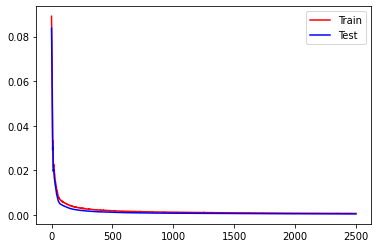

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx,lossy,'r',label = 'Train')
plt.plot(testx,testy,'b',label = 'Test')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

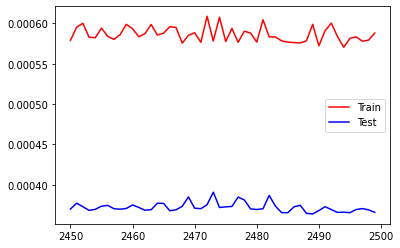

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx[-50:],lossy[-50:],'r',label = 'Train')
plt.plot(testx[-50:],testy[-50:],'b',label = 'Test')
plt.legend()
plt.show

## Baseline Loss

In [ ]:
model.eval()
with torch.no_grad():
  s_0 = torch.zeros(X_test.shape[0],hidden_dim).to(DEVICE)
  out = model(X_test, s_0)
  loss_val = loss_function(out[:,:future,:], y_test)
  print('Loss on Test: ',loss_val)

Loss on Test:  tensor(0.0004, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out[:,:future,:].to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())

33.5181325674057

In [ ]:
model.eval()
with torch.no_grad():
  s_0 = torch.zeros(X_train.shape[0],hidden_dim).to(DEVICE)
  out1 = model(X_train, s_0)
  loss_val1 = loss_function(out1[:,:future,:], y_train)
  print('Loss on Train: ',loss_val1)

Loss on Train:  tensor(0.0004, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out1[:,:future,:].to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

39.805036783218384

In [ ]:
model.eval()
with torch.no_grad():
  s_0 = torch.zeros(X_ds.astype('float32').shape[0],hidden_dim).to(DEVICE)
  out_complete = model(torch.from_numpy(X_ds.astype('float32')).to(DEVICE), s_0)
  loss_complete = loss_function(out_complete[:,:future,:], torch.from_numpy(y_ds.astype('float32')).to(DEVICE))
  print('Loss on Complete: ',loss_val)

Loss on Complete:  tensor(0.0004, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out_complete[:,:future,:].to('cpu').detach().numpy(),y_ds)

38.227341864507295

<function matplotlib.pyplot.show>

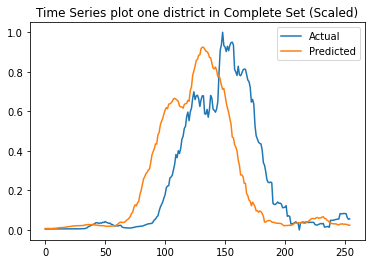

In [ ]:
i = 14                                                                            # district number
actual = X_ds[:,0,i]
pred = out_complete[:,:future,:].to('cpu').detach().numpy()[:,0,i]

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Scaled)')
plt.show

<function matplotlib.pyplot.show>

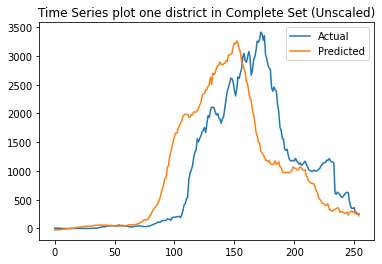

In [ ]:
i = 22                                                                            # district number
scale = scalers['scaler_'+ str(i)]
actual = scale.inverse_transform(X_ds[:,0,i].reshape(-1,1))
pred = scale.inverse_transform(out_complete[:,:future,:].to('cpu').detach().numpy()[:,0,i].reshape(-1,1))

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Unscaled)')
plt.show

# RHN Encoder Decoder

## Model Code

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [ ]:
class HSGLayer(nn.Module):
    def __init__(self, n_units, init_gates_closed):
        super(HSGLayer, self).__init__()
        self.W_R = nn.Linear(n_units, n_units, bias=False)
        self.W_F = nn.Linear(n_units, n_units)
        if init_gates_closed:
            self.W_F.bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
    def forward(self, s_L_t, s_prime_tm1):
        g = torch.sigmoid(self.W_R(s_prime_tm1) + self.W_F(s_L_t))
        s_prime_t = g*s_prime_tm1 + (1 - g)*s_L_t
        return s_prime_t

class RHNCell(nn.Module):
    def __init__(self, in_feats, n_units, rec_depth=3, couple_gates=True,
                 use_HSG=False, init_gates_closed=False):
        super(RHNCell, self).__init__()
        self.rec_depth = rec_depth
        self.in_feats = in_feats
        self.n_units = n_units
        self.couple_gates = couple_gates
        self.use_HSG = use_HSG
        self.W_H = nn.Linear(in_feats, n_units, bias=False)
        self.W_T = nn.Linear(in_feats, n_units, bias=False)
        if not couple_gates:
            self.W_C = nn.Linear(in_feats, n_units, bias=False)
        self.R_H = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        self.R_T = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        if not couple_gates:
            self.R_C = nn.ModuleList([nn.Linear(n_units, n_units) for _ in range(rec_depth)])
        
        if use_HSG:
            self.HSG = HSGLayer(n_units, init_gates_closed)
        
        if init_gates_closed:
            for l in range(rec_depth):
                self.R_T[l].bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
                if not couple_gates:
                    self.R_C[l].bias = nn.Parameter(torch.Tensor([-2.5]*n_units).cuda())
        
    def forward(self, x, s):
        if self.use_HSG:
            s_prime_tm1 = s
        preds = []
        for l in range(self.rec_depth):
            if l == 0:
                h_l_t = torch.tanh(self.W_H(x) + self.R_H[l](s))
                t_l_t = torch.sigmoid(self.W_T(x) + self.R_T[l](s))
                if not self.couple_gates:
                    c_l_t = torch.sigmoid(self.W_C(x) + self.R_C[l](s))
            else:
                h_l_t = torch.tanh(self.R_H[l](s))
                t_l_t = torch.sigmoid(self.R_T[l](s))
                if not self.couple_gates:
                    c_l_t = torch.sigmoid(self.R_C[l](s))
            
            if not self.couple_gates:
                s = h_l_t*t_l_t + c_l_t*s
            else:
                s = h_l_t*t_l_t + (1 - t_l_t)*s
            preds.append(s)
                
        if self.use_HSG:
            s = self.HSG(s, s_prime_tm1)
            preds.pop()
            preds.append(s)
        preds = torch.stack(preds)
        return s, preds

    
class RHN(nn.Module):
    def __init__(self, in_feats, out_feats, n_units=32, rec_depth=3, couple_gates=True, use_HSG=False,
                 init_gates_closed=False, use_batch_norm=False):
        super(RHN, self).__init__()
        assert rec_depth > 0
        self.rec_depth = rec_depth
        self.in_feats = in_feats
        self.n_units = n_units
        self.init_gates_closed = init_gates_closed
        self.couple_gates = couple_gates
        self.use_HSG = use_HSG
        self.use_batch_norm = use_batch_norm
        self.RHNCell = RHNCell(in_feats, n_units, rec_depth, couple_gates=couple_gates,
                               use_HSG=use_HSG, init_gates_closed=init_gates_closed)
        if use_batch_norm:
            self.bn_x = nn.BatchNorm1d(in_feats)
            self.bn_s = nn.BatchNorm1d(n_units)
    def forward(self, x):
        s = torch.zeros(x.shape[0], self.n_units).cuda()
        preds = []
        highway_states = []
        for t in range(x.shape[1]):
            if self.use_batch_norm:
                x_inp = self.bn_x(x[:, t, :])
                s = self.bn_s(s)
            else:
                x_inp = x[:, t, :]
            s, all_s = self.RHNCell(x_inp, s)
            preds.append(s)
            highway_states.append(all_s)
        preds = torch.stack(preds)
        preds = preds.permute(1, 0, 2)
        highway_states = torch.stack(highway_states)
        highway_states = highway_states.permute(2, 0, 3, 1)
        out = preds
        
        return out, highway_states


In [ ]:
class Encoder(nn.Module):
  def __init__(self,input_size,hidden_size,num_layers,batch):
    super(Encoder,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch = batch

    self.lstm = RHN(in_feats=self.input_size, out_feats=None, n_units=self.hidden_size, rec_depth=self.num_layers,
                    couple_gates=True, use_HSG=False, init_gates_closed=False, use_batch_norm=False)

  def forward(self, data):
    outputs, hidden = self.lstm(data)
    return hidden


class Decoder(nn.Module):
  def __init__(self,input_size,hidden_size,num_enc_lay,output_size,num_layers):    
    super(Decoder,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size*num_enc_lay
    self.output_size = output_size
    self.layers = num_layers

    self.lstmcell = RHNCell(in_feats=self.input_size, n_units=self.hidden_size,
                            rec_depth=self.layers, couple_gates=True,
                            use_HSG=False, init_gates_closed=False)
    self.fc = nn.Linear(self.hidden_size,self.output_size)

  def forward(self, x, hidden):
    hid = []
    out = []
    for b in range(x.shape[0]):
      s_b, hid_b = self.lstmcell(x[b,:], hidden[b,:,:])
      out_b = self.fc(s_b)
      hid.append(hid_b)
      out.append(out_b)
    
    out = torch.stack(out)
    hid = torch.stack(hid)

    return out, hid


class EncoderDecoderWrapper(nn.Module):
  def __init__(self, encoder, decoder, steps, output_size,num_dec_lay,seq_len):
    super(EncoderDecoderWrapper,self).__init__()
    self.output_size = output_size
    self.steps = steps

    self.encoder = encoder
    self.decoder = decoder
    self.out_layer = nn.Linear(num_dec_lay*seq_len*self.output_size,self.output_size)

  def forward(self, data, label, teacher_force):
    batch_size = data.shape[0]
    num_steps = self.steps

    hidden = self.encoder(data)
    hidden_size = hidden.shape[2]*hidden.shape[3]
    hidden = hidden.reshape(hidden.shape[0],hidden.shape[1],hidden_size)
    multi_step_out = torch.zeros(batch_size, num_steps, self.output_size).to(DEVICE)
    x = label[:,-1,:].view(batch_size,self.output_size)

    for t in range(num_steps):
      out, hidden = self.decoder(x, hidden)
      # print(out.size())
      # print(hidden.size())
      out = out.reshape(out.shape[0],-1)
      # print(out.shape)
      out = self.out_layer(out)
      # print(out.shape)
      multi_step_out[:,t,:] = out 
      x = label[:,t,:] if random.random() < teacher_force else out
      
    return multi_step_out

In [ ]:
def NonAttentionModel(INPUT_SIZE=1, HIDDEN_SIZE=30, NUM_LAYERS=1, DROPOUT=0.0, 
                      DEVICE=torch.device('cpu'), BIDIRECTIONAL=True, 
                      OUTPUT_SIZE=1, STEPS=1, NUM_DIR=1):
  
  encoder = Encoder(input_size=INPUT_SIZE,
                  hidden_size=HIDDEN_SIZE,
                  num_layers=NUM_LAYERS,
                  batch=False).to(DEVICE)

  decoder = Decoder(input_size=INPUT_SIZE,
                  hidden_size=HIDDEN_SIZE,
                  num_enc_lay=NUM_LAYERS,
                  num_layers=1,
                  output_size=OUTPUT_SIZE).to(DEVICE)

  net = EncoderDecoderWrapper(encoder = encoder,
                             decoder = decoder,
                             output_size = OUTPUT_SIZE,
                             steps = STEPS,
                             num_dec_lay = 1,
                             seq_len = window).to(DEVICE)
  return net

In [ ]:
INPUT_SIZE = ds.shape[1]
OUTPUT_SIZE = ds.shape[1]
HIDDEN_SIZE = 120
STEPS = future
NUM_LAYERS = 5
DROPOUT = 0.0
BIDIRECTIONAL = True
NUM_DIR = 2 if BIDIRECTIONAL == True else 1

net = NonAttentionModel(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, 
                         NUM_LAYERS=NUM_LAYERS, DROPOUT=DROPOUT, 
                         DEVICE=DEVICE, BIDIRECTIONAL=BIDIRECTIONAL, 
                         OUTPUT_SIZE=OUTPUT_SIZE, STEPS=STEPS, NUM_DIR=NUM_DIR)

print(net)

EncoderDecoderWrapper(
  (encoder): Encoder(
    (lstm): RHN(
      (RHNCell): RHNCell(
        (W_H): Linear(in_features=36, out_features=120, bias=False)
        (W_T): Linear(in_features=36, out_features=120, bias=False)
        (R_H): ModuleList(
          (0): Linear(in_features=120, out_features=120, bias=True)
          (1): Linear(in_features=120, out_features=120, bias=True)
          (2): Linear(in_features=120, out_features=120, bias=True)
          (3): Linear(in_features=120, out_features=120, bias=True)
          (4): Linear(in_features=120, out_features=120, bias=True)
        )
        (R_T): ModuleList(
          (0): Linear(in_features=120, out_features=120, bias=True)
          (1): Linear(in_features=120, out_features=120, bias=True)
          (2): Linear(in_features=120, out_features=120, bias=True)
          (3): Linear(in_features=120, out_features=120, bias=True)
          (4): Linear(in_features=120, out_features=120, bias=True)
        )
      )
    )
  )
  (d

In [ ]:
# out = net(X_train, y_train, 0.5)

In [ ]:
loss_function = nn.SmoothL1Loss()
optimizer = opt.Adam(net.parameters(),lr=5e-3)
scheduler = None #opt.lr_scheduler.StepLR(optimizer,300,0.5)

## Training

In [ ]:
net.train()
thres = 10000
EPOCH = 2000
TEACHER_FORCE_RATIO = 0.5
lossx = [i for i in range(EPOCH)]
testx= [i for i in range(EPOCH)]
lossy,testy= [],[]
for epoch in range(EPOCH):
    cumloss=0
    testloss=0

    net.zero_grad()
    optimizer.zero_grad()
    
    out = net(X_train, y_train, TEACHER_FORCE_RATIO)
    
    loss=loss_function(out, y_train)
    loss.backward()
    mape_train = mean_absolute_percentage_error(out.to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

    nn.utils.clip_grad_value_(net.parameters(), clip_value=1.0)
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    
    cumloss += float(loss.data)
    lossy.append(cumloss)
    net.eval()
    with torch.no_grad():
        out_test = net(X_test,y_test,TEACHER_FORCE_RATIO)
        loss_test = loss_function(out_test, y_test)
        testloss += float(loss_test.data)
        mape_test = mean_absolute_percentage_error(out_test.to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())
        testy.append(testloss)
        if testloss < thres:
          torch.save({
              'state_dict': net.state_dict(),
              'trainloss': lossy,
              'testloss': testy,
              'optimizer_state_dict': optimizer.state_dict(),
              'epoch': epoch,
              'teacher_force_ratio': TEACHER_FORCE_RATIO
          },'/gdrive/MyDrive/Trip-AID/Models/RHN_ENCODER_DECODER.pt')
    net.train()

    if (epoch+1) % 100 == 0:
        print('Epoch:', epoch+1,'/', EPOCH, '| Training Loss:', cumloss, '| Test Loss:', testloss)
        print('MAPE: (a) Train:', mape_train,' (b) Test:', mape_test )

Epoch: 100 / 2000 | Training Loss: 0.0018428269540891051 | Test Loss: 0.001914379419758916
MAPE: (a) Train: 80.03725409507751  (b) Test: 157.558274269104
Epoch: 200 / 2000 | Training Loss: 0.001071360893547535 | Test Loss: 0.0010686125606298447
MAPE: (a) Train: 81.59078359603882  (b) Test: 59.19160842895508
Epoch: 300 / 2000 | Training Loss: 0.0008337764884345233 | Test Loss: 0.0007911795983090997
MAPE: (a) Train: 132.2410225868225  (b) Test: 72.83886671066284
Epoch: 400 / 2000 | Training Loss: 0.00066596973920241 | Test Loss: 0.00067110889358446
MAPE: (a) Train: 47.21565544605255  (b) Test: 49.059757590293884
Epoch: 500 / 2000 | Training Loss: 0.0005539406556636095 | Test Loss: 0.000568885006941855
MAPE: (a) Train: 51.63900852203369  (b) Test: 43.81442368030548
Epoch: 600 / 2000 | Training Loss: 0.00048811157466843724 | Test Loss: 0.0004986200947314501
MAPE: (a) Train: 40.25663733482361  (b) Test: 76.02429986000061
Epoch: 700 / 2000 | Training Loss: 0.0004667669127229601 | Test Loss: 

## Loss Plots

In [ ]:
net = NonAttentionModel(INPUT_SIZE=INPUT_SIZE, HIDDEN_SIZE=HIDDEN_SIZE, 
                         NUM_LAYERS=NUM_LAYERS, DROPOUT=DROPOUT, 
                         DEVICE=DEVICE, BIDIRECTIONAL=BIDIRECTIONAL, 
                         OUTPUT_SIZE=OUTPUT_SIZE, STEPS=STEPS, NUM_DIR=NUM_DIR)
optimizer = opt.Adam(net.parameters(),lr=5e-3)

checkpoint = torch.load('/gdrive/MyDrive/Trip-AID/Models/RHN_ENCODER_DECODER.pt')

net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epochs = checkpoint['epoch']
lossy = checkpoint['trainloss']
testy = checkpoint['testloss']
lossx = [i for i in range(epochs+1)]
testx= [i for i in range(epochs+1)]

TEACHER_FORCE_RATIO = checkpoint['teacher_force_ratio']

net.eval()

EncoderDecoderWrapper(
  (encoder): Encoder(
    (lstm): RHN(
      (RHNCell): RHNCell(
        (W_H): Linear(in_features=36, out_features=120, bias=False)
        (W_T): Linear(in_features=36, out_features=120, bias=False)
        (R_H): ModuleList(
          (0): Linear(in_features=120, out_features=120, bias=True)
          (1): Linear(in_features=120, out_features=120, bias=True)
          (2): Linear(in_features=120, out_features=120, bias=True)
          (3): Linear(in_features=120, out_features=120, bias=True)
          (4): Linear(in_features=120, out_features=120, bias=True)
        )
        (R_T): ModuleList(
          (0): Linear(in_features=120, out_features=120, bias=True)
          (1): Linear(in_features=120, out_features=120, bias=True)
          (2): Linear(in_features=120, out_features=120, bias=True)
          (3): Linear(in_features=120, out_features=120, bias=True)
          (4): Linear(in_features=120, out_features=120, bias=True)
        )
      )
    )
  )
  (d

<function matplotlib.pyplot.show>

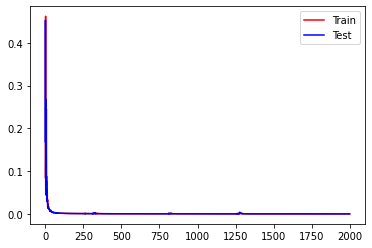

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx,lossy,'r',label = 'Train')
plt.plot(testx,testy,'b',label = 'Test')
plt.legend()
plt.show

<function matplotlib.pyplot.show>

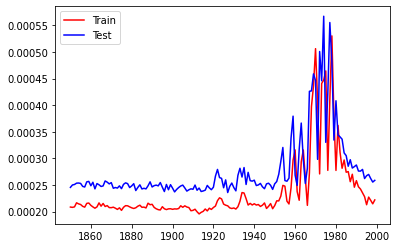

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lossx[-150:],lossy[-150:],'r',label = 'Train')
plt.plot(testx[-150:],testy[-150:],'b',label = 'Test')
plt.legend()
plt.show

## Baseline Loss

In [ ]:
net.eval()
with torch.no_grad():
  out = net(X_test, y_test, 0.5)
  loss_val = loss_function(out, y_test)
  print('Loss on Test: ',loss_val)

Loss on Test:  tensor(0.0003, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out.to('cpu').detach().numpy(),y_test.to('cpu').detach().numpy())

43.55161786079407

In [ ]:
net.eval()
with torch.no_grad():
  out1 = net(X_train, y_train, TEACHER_FORCE_RATIO)
  loss_val1 = loss_function(out1, y_train)
  print('Loss on Train: ',loss_val1)

Loss on Train:  tensor(0.0002, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out1.to('cpu').detach().numpy(),y_train.to('cpu').detach().numpy())

52.25974917411804

In [ ]:
net.eval()
with torch.no_grad():
  out_complete = net(torch.from_numpy(X_ds.astype('float32')).to(DEVICE), torch.from_numpy(y_ds.astype('float32')).to(DEVICE), TEACHER_FORCE_RATIO)
  loss_complete = loss_function(out_complete, torch.from_numpy(y_ds.astype('float32')).to(DEVICE))
  print('Loss on Complete: ',loss_val)

Loss on Complete:  tensor(0.0003, device='cuda:0')


In [ ]:
mean_absolute_percentage_error(out_complete.to('cpu').detach().numpy(),y_ds)

32.4039204768595

<function matplotlib.pyplot.show>

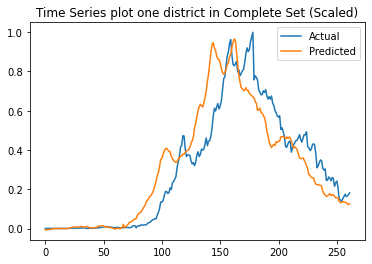

In [ ]:
i = 0                                                         # district number
actual = X_ds[:,0,i]
pred = out_complete.to('cpu').detach().numpy()[:,0,i]

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Scaled)')
plt.show

<function matplotlib.pyplot.show>

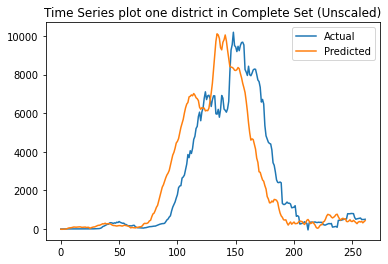

In [ ]:
i = 14                                                                            # district number
scale = scalers['scaler_'+ str(i)]
actual = scale.inverse_transform(X_ds[:,0,i].reshape(-1,1))
pred = scale.inverse_transform(out_complete.to('cpu').detach().numpy()[:,0,i].reshape(-1,1))

plt.plot(actual,label = 'Actual')
plt.plot(pred,label = 'Predicted')
plt.legend()
plt.title('Time Series plot one district in Complete Set (Unscaled)')
plt.show